# SQL, Tableau, and Forecasting on US Pollution Data
---
**Keywords**:<br>
SQL, Tableau, Timeseries, Forecasting, Pandas, Environment

## Introduction
<p>
    This dataset was obtained on <a href="https://www.kaggle.com/sogun3/uspollution">kaggle</a>. The link contains the complete description but all you need to know to understand this analysis will be defined here. 
</p>

<p>
    I put a few comments on throughout the analysis to either clarify some points or give my opinion on a subject. Those are presented in blockquotes colored in dark blue. <br>
<blockquote>
    <font color="darkblue">This is a comment! I hope you enjoy this work and can get some useful insight or piece of code from it.</font>
</blockquote>
</p>



### Contents

![](https://i.imgur.com/aptQbQK.png)

### Objectives
- Pre-process the data using PostgreSQL 
- Query the data needed for this analysis: last 6 years of the dataset
- Build dashboards for exploration using Tableau
- Analyse the time components of each pollutant
- Build Naive Models as a comparison
- Forecast using SARIMA models

### TLDR Version <font color="firebrick">(Under construction)</font>

...

---

---

# 1 - The Dataset
---
## 1.1 - Introducing the Data

### General Information
- Original format: csv
- Dataset shape: 1.746.661 x 30 (rows x columns)
- Granularity: Combination of State-County-City-Site_num-Date_local features
- Usability: Many nulls and duplicates. See chapter 1.3.

### Features in the dataset

<ul>
    <li><b>Id</b> - Not unique integer</li>
    <li><b>State_code</b></li>
    <li><b>Country_code</b></li>
    <li><b>Site_num</b>- Number of measurement site</li>
    <li><b>Address, State_name, County, City</b></li>
    <li><b>date_local</b> - Date of the measurement</li>
    <li><b>(*4x) Unit</b> - Unit of the measurement</li>
    <li><b>(4x) Mean</b></li>
    <li><b>(4x) Max_value</b></li>
    <li><b>(4x) Max_hour</b> - Hour of the max value</li>
    <li><b>(4x) AQI</b> - <a href='https://www.weather.gov/safety/airquality-aqindex'>Air Quality Index</a>. A standard measure for air quality that can be used to compare pollutants. <u>Since AQI allows us to compare different pollutants, we won't use the other pollutant features.</u> There are AQI bands according to risk to health. The bands are defined on the image below.</li> 

</ul>

![](http://sparetheair.com/assets/aqi/PM2017.png)

<p>
    <b>*</b> Each feature with the 4x indicator means they repeat for the four pollutants in our dataset: <b>NO2, O3, SO2 and CO.</b>
</p>

### The Pollutants
As mentioned, we have four pollutants. This image describes them briefly (Source: wikipedia).
![](https://i.imgur.com/oyhrJKd.png)


<hr>

## 1.2 -  Importing Libraries

We need only the basic tools for an EDA for now.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='whitegrid', rc={'axes.grid': False})

<hr/>

## 1.3 - Data Pre-Processing
The tool used for reading and preprocessing this dataset was PostgreAdmin together with PostgreSQL queries. My resources are limited and demand SQL data optimization for larger datasets.

As mentioned, the inital dataset has over 1.7 million lines, but as soon as you take your first look at it you notice that there are many problems going on. To illustrate this I took what should supposedly be a single row of data from SQL using the following SQL query:

```SQL
select 
	state_name, city, date_local,
	no2_mean, no2_max_value, no2_aqi,
	o3_mean, o3_max_value, o3_aqi,
	so2_mean, so2_max_value, so2_aqi,
	co_mean, co_max_value, co_aqi 
from us_pollution
where
	state_name = 'Illinois' and
	county = 'Cook' and
	city = 'Northbrook' and
	site_num = 4201 and
	date_local = date('2007-05-15');
```
The data from this query is presented below.

In [2]:
sample_data = pd.read_csv('../input/sample-query/sample_query.csv')
sample_data.iloc[:,3:]

,no2_mean,no2_max_value,no2_aqi,o3_mean,o3_max_value,o3_aqi,so2_mean,so2_max_value,so2_aqi,co_mean,co_max_value,co_aqi
0,7.000000,13,12,0.034375,0.044,37,0.791667,3,4.0,0.361250,0.42,NaN
1,8.458333,13,12,0.034375,0.044,37,0.787500,3,NaN,0.379167,0.40,5.0
2,8.458333,13,12,0.027042,0.034,29,0.791667,3,4.0,0.361250,0.42,NaN
3,8.458333,13,12,0.027042,0.034,29,0.791667,3,4.0,0.379167,0.40,5.0
4,8.458333,13,12,0.027042,0.034,29,0.787500,3,NaN,0.361250,0.42,NaN
5,8.458333,13,12,0.027042,0.034,29,0.787500,3,NaN,0.379167,0.40,5.0
6,7.000000,13,12,0.034375,0.044,37,0.791667,3,4.0,0.379167,0.40,5.0
7,7.000000,13,12,0.034375,0.044,37,0.787500,3,NaN,0.361250,0.42,NaN
8,7.000000,13,12,0.034375,0.044,37,0.787500,3,NaN,0.379167,0.40,5.0
9,7.000000,13,12,0.027042,0.034,29,0.791667,3,4.0,0.361250,0.42,NaN


For what should be a single measure we have 16. I've decided to explore only the AQI columns and that means I can drop the nulls and just group the data and get the average AQI values. From 1.7mi now we have something around 400k rows.


<blockquote>
    <font color='darkblue'>
        <b>If we wanted to use the other features</b>, we should use a MAX( ) aggregation function for the max values. To get the hour for this max value things would get a more complicated. There is no way to aggregate the hour values in a way that picks the right information so you would probably want to create a query without the hour values and join to the original table.
    </font>
    </blockquote>

<hr>

## 1.4 - Querying
As stated in the **objectives**, we will use on the last six years of this dataset (from 2011 to 2016). Another important thing is to look if the cities are present in all years. Having cities joining and leaving the data throughout the time period will mess with any analysis. A SQL query can expose this problem:
```SQL
select 
	state_name, county, 
	city, site_num,
	count(distinct(extract(year from date_local))) years
from 
	us_pollution
where 
	date_local > date('2010-12-31')
group by 
	state_name, county,
	city, site_num
having 
    years = 6;
```

The output of this query is 51 lines of locations that are present in the six years of our analysis - applying those as a filter results in approximately 88k rows.

That's it for the pre-processing and we're ready to explore.

In [3]:
dataset = pd.read_csv('../input/cleaned-us-pollution/us_pollution_cleaned_v3.csv')
dataset.sample(5)

,state_name,county,city,site_num,date_local,no2_aqi,o3_aqi,so2_aqi,co_aqi
68283,Pennsylvania,Cambria,Johnstown,11,2013-11-22,27.0,24.0,11.0,10.0
19328,California,Sacramento,Arden-Arcade,6,2015-08-05,16.0,61.0,1.0,2.0
60091,North Carolina,Mecklenburg,Charlotte,41,2014-09-07,8.0,39.0,0.0,2.0
86267,Wyoming,Laramie,Not in a city,100,2011-12-12,32.0,30.0,1.0,2.0
74414,Texas,Dallas,Dallas,69,2012-10-26,8.0,20.0,0.0,1.0


<hr>

<hr>

# 2 - Exploratory Data Analysis
I've decided for this kernel to do the exploratory visualization on Tableau and build dashboards so you can do the data exploration as well. 

**Dashboard One** shows an overview of all cities in the dataset, which is to help you choose which one you want to further explore in **Dashboard Two**.

<hr>

## 2.1 - US Dashboard

This dashboard shows a ranking of cities and an interactive map. You can choose which pollutant to look and if you want to look for Average values or Maximum values of AQI. Below the ranking there is an interactive map, showing the same results.

The idea is to have an overall visualization on this first dashboard, pick a city and look it up on the second dashboard.

In [4]:
%%HTML
<div class='tableauPlaceholder' id='viz1564931468161' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;4R&#47;4RXN929JT&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='path' value='shared&#47;4RXN929JT' /> <param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;4R&#47;4RXN929JT&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1564931468161');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.maxWidth='750px';vizElement.style.height=(divElement.offsetWidth*0.85)+'px';vizElement.style.maxHeight='1187px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

<hr>

## 2.2 - City Dashboard
The second dashboard is ment to look at each individual city for a deeper analysis on the data. You can see how each city progresses over the time period using the time filter. Once more, you can choose the pollutant and the city you would like to see in the interactive filters.

In [5]:
%%HTML
<div class='tableauPlaceholder' id='viz1564066138024' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;US&#47;US_pollution&#47;CityDashboard&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='US_pollution&#47;CityDashboard' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;US&#47;US_pollution&#47;CityDashboard&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1564066138024');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.maxWidth='750px';vizElement.style.height=(divElement.offsetWidth*0.85)+'px';vizElement.style.maxHeight='1187px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

<hr>

## 2.3 - Grouped Data
How is the overall air quality index? We can answer this question grouping by dates. This is how our grouped data looks like:

In [6]:
pollutants = ['no2_aqi', 'o3_aqi', 'so2_aqi', 'co_aqi']

grouped_data = dataset.groupby('date_local').mean().drop('site_num', axis=1)
grouped_data.index = pd.to_datetime(grouped_data.index)
grouped_data.head()

,no2_aqi,o3_aqi,so2_aqi,co_aqi
date_local,,,,
2011-01-01,21.125000,24.950000,4.550000,5.812500
2011-01-02,22.925000,25.100000,4.925000,5.425000
2011-01-03,27.634146,22.902439,3.548780,6.512195
2011-01-04,30.525000,20.425000,7.587500,7.512500
2011-01-05,31.357143,20.238095,6.464286,7.547619


Now, we have a daily data of the AQI averaged between cities across the US. With our grouped data we can plot all the pollutants indexes between 2011 and 2016. The graph is presented below - once more using Tableau. 

However, it is also easy to do it using pandas. Simply using <code>grouped_data.plot()</code> would result in a similar graph using the default settings.

In [7]:
%%HTML
<div class='tableauPlaceholder' id='viz1564414530161' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;US&#47;US_pollution_grouped&#47;DB2&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='US_pollution_grouped&#47;DB2' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;US&#47;US_pollution_grouped&#47;DB2&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1564414530161');                    var vizElement = divElement.getElementsByTagName('object')[0];                  
vizElement.style.width='100%';
vizElement.style.height='620px'
vizElement.style.maxHeight='620px';
var scriptElement = document.createElement('script');
scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    
vizElement.parentNode.insertBefore(scriptElement, vizElement);  
</script>

**Insights from the plot:**
- On a first look, CO, NO2 and O3 apparently have yearly patterns, while SO2 looks like quite noisy (we will explore that later);
- Ozone is produced by sunlight and is correlated to traffic volumes and the july and august peaks are observed accordingly;  
- Curiously, Ozone's pattern behaves in the opposite way of CO and NO2 and I have no explanation for that. 

We mustn't forget that these are averages and we don't know how distributed the values are. A way to visualize how clear these patterns are is by plotting a confidence interval for each time series. We will plot each pollutant separatedly to avoid making the graph too visually polluted (pun not intended). 

<hr>

## 2.4 - Confidence Bands

The graph below presents the daily average and a confidence band of 95% (-2/+2 standard deviations) measured on the 6 years of data for each pollutant. 

In [8]:
%%HTML
<div class='tableauPlaceholder' id='viz1564414741872' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;US&#47;US_pollution_grouped&#47;DB1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='US_pollution_grouped&#47;DB1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;US&#47;US_pollution_grouped&#47;DB1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1564414741872');                    var vizElement = divElement.getElementsByTagName('object')[0];               
vizElement.style.width='100%';
vizElement.style.height='620px'
vizElement.style.maxHeight='620px';
var scriptElement = document.createElement('script');    
scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';   
vizElement.parentNode.insertBefore(scriptElement, vizElement);       
</script>

**There is a large confidence interval for O3 and NO2. I can think of three reasons for that:**
1. The cities vary a lot on those two pollutants and different cities behave differently
2. The data is simply very disperse for those pollutants
3. Both cities and data are disperse (1 and 2 together).  

Let's look at two cities - Dallas and New York - and see if we can figure out which option is it. The code below queries for both cities and groups the data like we did in the plot just above for Ozone to illustrate how we could reproduce this graph with simple Python.

In [9]:
## Dallas Data
# Querying the city
dallas = dataset.query("city == 'Dallas'").copy()

# Creating a day of year column using pandas datetime properties
dallas.loc[:, 'date'] = pd.to_datetime(dallas.loc[:, 'date_local'])
dallas.loc[:, 'day_of_year'] = dallas['date'].apply(lambda x: x.dayofyear)

# Grouping the dataset with day of year and creating upper and lower limits for the 
# confidence interval using two standard deviations
grouped_dallas = dallas[['day_of_year', 'o3_aqi']].groupby('day_of_year').aggregate(['mean', 'std'])
grouped_dallas['upper'] = grouped_dallas['o3_aqi', 'mean'] + 2 * grouped_dallas['o3_aqi', 'std']
grouped_dallas['lower'] = grouped_dallas['o3_aqi', 'mean'] - 2 * grouped_dallas['o3_aqi', 'std']

# New York Data
# Querying the city
nyork = dataset.query("city == 'New York'").copy()

# Creating a day of year column using pandas datetime properties
nyork.loc[:, 'date'] = pd.to_datetime(nyork.loc[:, 'date_local'])
nyork.loc[:, 'day_of_year'] = nyork.loc[:, 'date'].apply(lambda x: x.dayofyear)

# Grouping the dataset with day of year and creating upper and lower limits for the 
# confidence interval using two standard deviations
grouped_nyork = nyork[['day_of_year', 'o3_aqi']].groupby('day_of_year').aggregate(['mean', 'std'])
grouped_nyork['upper'] = grouped_nyork['o3_aqi', 'mean'] + 2 * grouped_nyork['o3_aqi', 'std']
grouped_nyork['lower'] = grouped_nyork['o3_aqi', 'mean'] - 2 * grouped_nyork['o3_aqi', 'std']

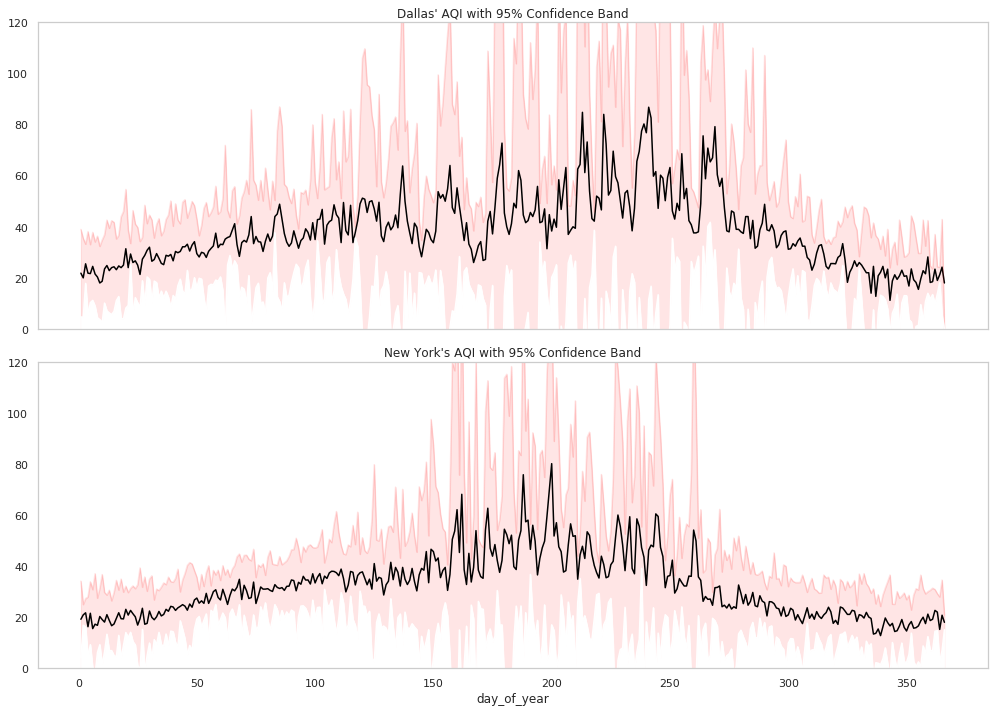

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(14,10), sharex=True)
grouped_dallas.plot(y=('o3_aqi', 'mean'), kind='line', ax=axes[0], stacked=False, color='black')
grouped_dallas.plot(y='upper', kind='area', ax=axes[0], stacked=False, color='red', alpha=0.1)
grouped_dallas.plot(y='lower', kind='area', ax=axes[0], stacked=False, color='white', alpha=1)
axes[0].set_ylim(0, 120)
axes[0].legend().set_visible(False)
axes[0].set_title("Dallas' AQI with 95% Confidence Band")

grouped_nyork.plot(y=('o3_aqi', 'mean'), kind='line', ax=axes[1], stacked=False, color='black')
grouped_nyork.plot(y='upper', kind='area', ax=axes[1], stacked=False, color='red', alpha=0.1)
grouped_nyork.plot(y='lower', kind='area', ax=axes[1], stacked=False, color='white', alpha=1)
axes[1].set_ylim(0, 120)
axes[1].legend().set_visible(False)
axes[1].set_title("New York's AQI with 95% Confidence Band")
plt.tight_layout();

We can see that the peaks are not necessarily alligned for both cities - **Reason 1** stated before. For instance, at day 200 we have normal values in Dallas and a peak in New York.

We can also notice that within 6 years the data has a large confidence interval (i.e. data itself is spread out - **Reason 2**). So apparently both are correct for Ozone. Due to Ozone's high correlation with sun irradiation and sunlight exposure it is plausible that peaks don't allign.

Also, due to the fact that peaks don't happen simultaneously on different cities, we have the large confidence band we see on the last Tableau plot.

<hr>

## 2.5 - Time Decomposition
For the last part of our exploratory data analysis we will decompose our grouped data into **Trend, Seasonal and Residual**. 

I will borrow the definition of Trend and Seasonality from the amazing free book <b><a href='https://otexts.com/fpp2/'>Forecasting: Principles and Practice</a></b> by Rob J Hyndman and George Athanasopoulos:
<br><br>
<p><font color='darkgreen'>
    <b>"Trend</b>: <i>A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear. Sometimes we will refer to a trend as “changing direction”, when it might go from an increasing trend to a decreasing trend."</i>
</font></p>
<p><font color='darkgreen'>
    <b>"Seasonality</b>: <i>A seasonal pattern occurs when a time series is affected by seasonal factors such as the time of the year or the day of the week. Seasonality is always of a fixed and known frequency."</i>
</font></p>
<br>
A trend should tell us if the average values are changing over the years. The seasonality in our case happens yearly, as we've seen in the previous plots.

The **Residual** component is whatever is not explained by the other two. The residual plot should be with mean 0 and constant variation through time. If that's not the case there might be something not being accounted for in the other two components.

**Statsmodels** provides the function <code>seasonal_decompose()</code> that does this decomposition for us. 

<blockquote>
    <font color='darkblue'>
Our data's granularity is in days and your seasonal patterns are yearly so we must set the <b>frequency to 365</b>.

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
no2_dec = seasonal_decompose(grouped_data['no2_aqi'], model='additive', freq=365)
o3_dec = seasonal_decompose(grouped_data['o3_aqi'], model='additive', freq=365)
so2_dec = seasonal_decompose(grouped_data['so2_aqi'], model='additive', freq=365)
co_dec = seasonal_decompose(grouped_data['co_aqi'], model='additive', freq=365)

I've plotted two groups: NO2/O3 and SO2/CO because the range of values is similar and I can use the same Y-limits. 

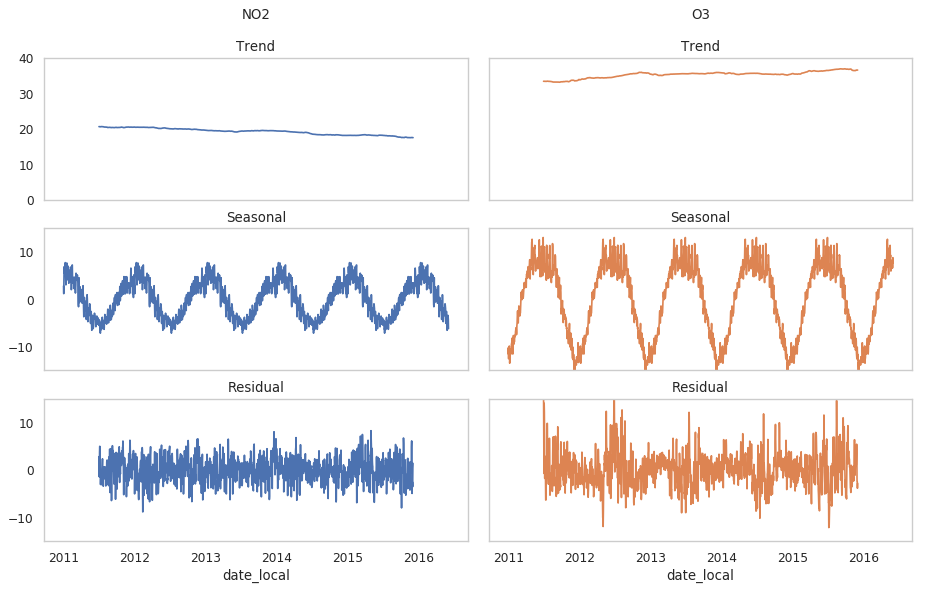

In [12]:
fig, axes = plt.subplots(3,2, figsize=(14,8), sharex=True, sharey='row', dpi=80)

axes[0][0].set_title('NO2\n\nTrend')
axes[1][0].set_title('Seasonal')
axes[2][0].set_title('Residual')
no2_dec.trend.plot(ax=axes[0][0], ylim=(0, 40), c='C0')
no2_dec.seasonal.plot(ax=axes[1][0], ylim=(-15, 15), c='C0')
no2_dec.resid.plot(ax=axes[2][0], ylim=(-15, 15), c='C0')

axes[0][1].set_title('O3\n\nTrend')
axes[1][1].set_title('Seasonal')
axes[2][1].set_title('Residual')
o3_dec.trend.plot(ax=axes[0][1], ylim=(0, 40), c='C1')
o3_dec.seasonal.plot(ax=axes[1][1], ylim=(-15, 15), c='C1')
o3_dec.resid.plot(ax=axes[2][1], ylim=(-15, 15), c='C1')
fig.subplots_adjust(wspace=0.05);

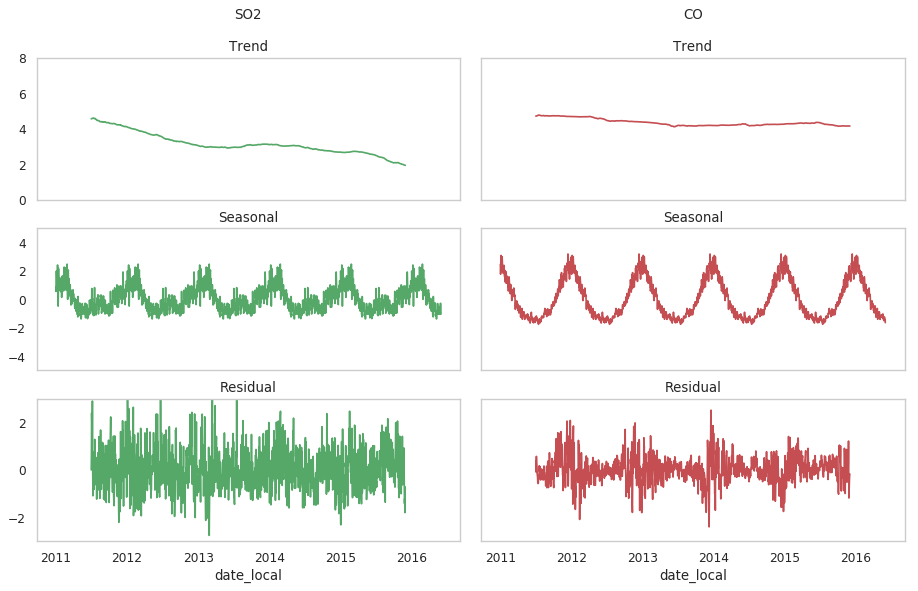

In [13]:
fig, axes = plt.subplots(3,2, figsize=(14,8), sharex=True, sharey='row', dpi=80)

axes[0][0].set_title('SO2\n\nTrend')
axes[1][0].set_title('Seasonal')
axes[2][0].set_title('Residual')
so2_dec.trend.plot(ax=axes[0][0], ylim=(0, 8), c='C2')
so2_dec.seasonal.plot(ax=axes[1][0], ylim=(-5, 5), c='C2')
so2_dec.resid.plot(ax=axes[2][0], ylim=(-3, 3), c='C2')

axes[0][1].set_title('CO\n\nTrend')
axes[1][1].set_title('Seasonal')
axes[2][1].set_title('Residual')
co_dec.trend.plot(ax=axes[0][1], ylim=(0, 8), c='C3')
co_dec.seasonal.plot(ax=axes[1][1], ylim=(-5, 5), c='C3')
co_dec.resid.plot(ax=axes[2][1], ylim=(-3, 3), c='C3')
fig.subplots_adjust(wspace=0.05)

**Trends:**
- Ozone is slightly increasing
- SO2 is crearly decreasing
- CO and NO2 are hard to tell but seem to be slightly decreasing

**Seasonal Patterns**
- All four pollutants seem to have seasonal patterns
- CO has the less noisy pattern
- O3 has the highest pattern amplitude

**Residuals**:
- All residuals are really high compared to the trend and seasonal components. 
- The mean is approximately zero for all residuals
- The variance is also not constant through time

<hr>

## 2.6 - Train and Test sets
We will be trying to train a model to predict six months into the future. Therefore, our test set should be of at least six months. 

That said, our test set will be the last six months in our data and the rest will be used as training (this means test interval is from october 2015 to march 2016). From now on we won't touch the data from the test set.

In [14]:
train = grouped_data[:'2015-10-01']
test = grouped_data['2015-10-01':'2016-03-31']

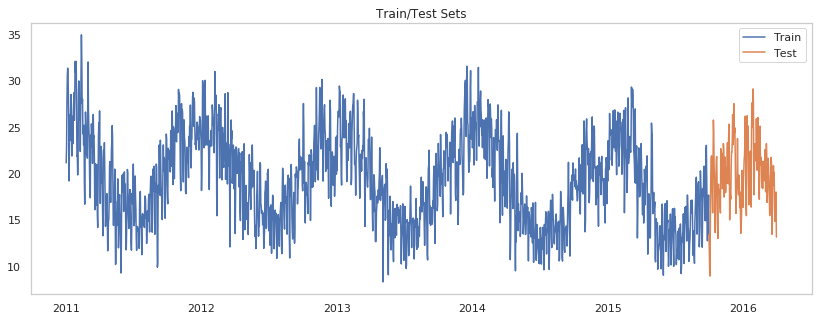

In [15]:
plt.figure(figsize=(14,5))
plt.plot(train.index, train['no2_aqi'], label='Train')
plt.plot(test.index, test['no2_aqi'], color='C1', label='Test')
plt.legend()
plt.title('Train/Test Sets');

<hr>

<hr>

# 3 - Naive Models
The first models we are going to use to forecast will be three naive models for two reasons:
1. Some times a simpler solution is good enough
2. We will have something to compare our other higher complexity models

The naive models we are going to use are:
- **Average Method**: The prediction is simply the average of the past values
- **Naive Method**: The prediction is simply the last value on the training data
- **Seasonal Naive Method**: The prediction is the same value in the last seasonal period (i.e. last year for our data)

We will be measuring the performance with **root mean squared error** and **mean absolute error**. Let's start forecasting.

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Creating a dataframe to store scores
mindex = pd.MultiIndex.from_product(iterables=(['RMSE', 'MAE'], \
                                               ['Average', 'Naive',
                                                'Seasonal_Naive']))
fc_scores = pd.DataFrame(index=mindex, columns=test.columns)

The cell belows defines a function to save the values in our scores table and another function plot the forecasts for each method. We will be using them frequently.

In [17]:
def store_scores(method, predictions):
    for pol in pollutants:
        mse = mean_squared_error(test[pol], predictions[pol])
        mae = mean_absolute_error(test[pol], predictions[pol])
        fc_scores.loc[('RMSE', method), pol] = np.sqrt(mse)
        fc_scores.loc[('MAE', method), pol] = mae
        
        
def plot_forecast(predictions):
    fig, axes = plt.subplots(2, 2, figsize=(15,8), dpi=80, sharex=True)
    fig.subplots_adjust(wspace=0.1, hspace=0.1)

    axlist = [(0, 0), (0, 1), (1, 0), (1, 1)]

    for (i, j), pol in zip(axlist, pollutants):
        axes[i][j].plot(train.loc['2015':, pol], lw=0.75, label='Train')
        axes[i][j].plot(test[pol], lw=0.75, label='Test', c='darkgray')
        axes[i][j].plot(predictions[pol], c='red', lw=2, ls='--', label='Forecast')
        axes[i][j].set_title(pol)

    axes[0][0].legend(bbox_to_anchor=[1.35, 1.15], ncol=3);

<hr>

## 3.1 - Average Method
For the average method, we just need to take the average of the training data.

In [18]:
avg_predictions = pd.DataFrame(index=test.index, columns=test.columns)
for i in range(4):
    avg_predictions.iloc[:,i] = train.iloc[:,i].mean()
    
store_scores('Average', avg_predictions)

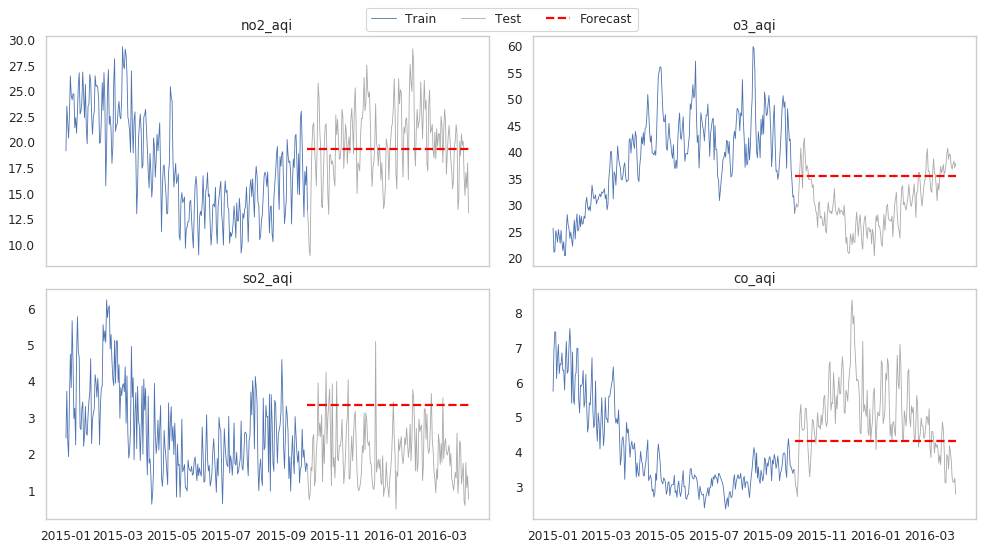

In [19]:
plot_forecast(avg_predictions)

<hr>

## 3.2- Naive Method
The naive method consists of picking the last value and using it as a forecast. Another one-liner.

In [20]:
naive_predictions = pd.DataFrame(index=test.index, columns=test.columns)
for i in range(4):
    naive_predictions.iloc[:,i] = train.iloc[-1,i]
    
store_scores('Naive', naive_predictions)

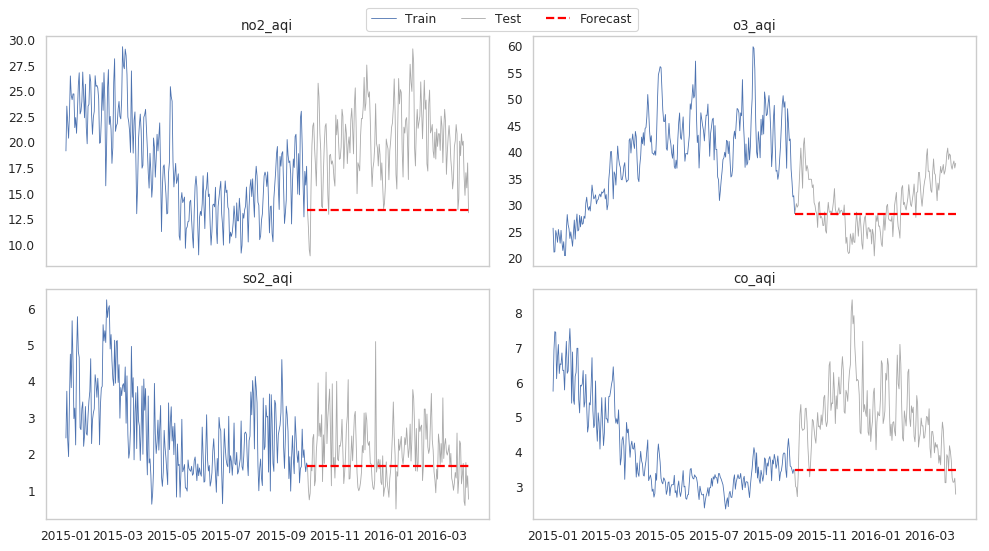

In [21]:
plot_forecast(naive_predictions)

<hr>

## 3.3 - Seasonal Naive Method
Similar to the naive method but with a seasonal offset. On this method, in order to forecast march 21st we use the value of march 21st of the previous year. Unfortunately, february in our test data has 29 days so we will just repeat the value of february 28th (a two-liner, thanks to the leap year).

In [22]:
sn_predictions = pd.DataFrame(index=test.index, columns=test.columns)
for pol in pollutants:
    sn_predictions.loc['2015-10-01':'2016-02-28',pol] = \
        train.loc['2014-10-01':'2015-02-28',pol].values
    sn_predictions.loc['2016-02-29':'2016-03-31',pol] = \
        train.loc['2015-02-28':'2015-03-31',pol].values
    
# Storing scores
store_scores('Seasonal_Naive', sn_predictions)

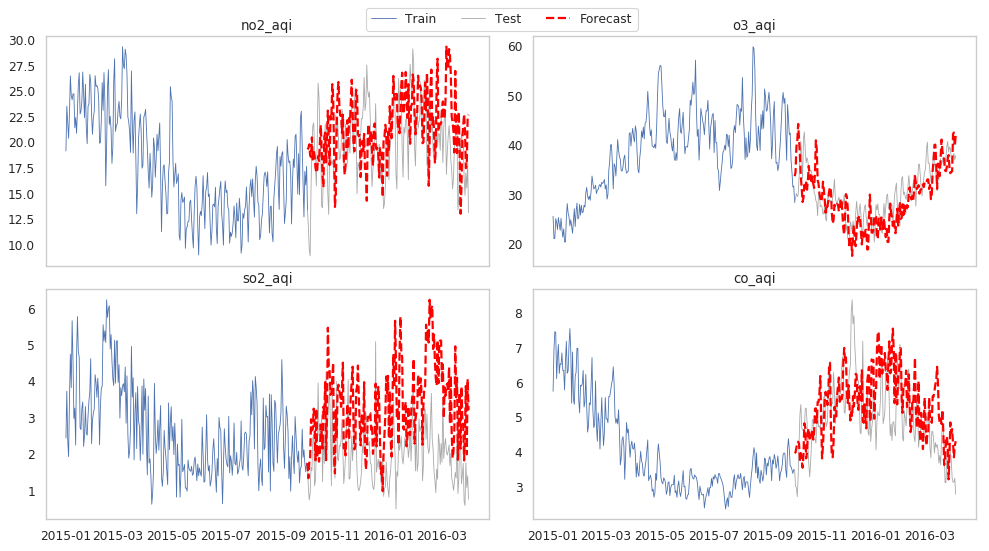

In [23]:
plot_forecast(sn_predictions)

<hr>

## 3.4 - Scores
Now that we have our three naive models ready, let's see which ones are best suited for each pollutant. 

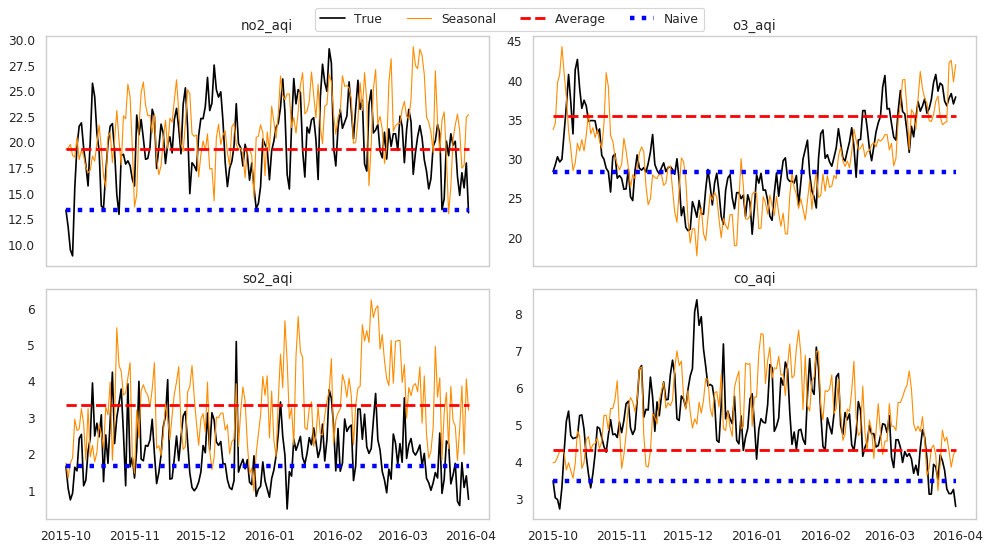

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(15,8), dpi=80, sharex=True)
fig.subplots_adjust(wspace=0.1, hspace=0.1)

axlist = [(0, 0), (0, 1), (1, 0), (1, 1)]

for (i, j), pol in zip(axlist, pollutants):
    axes[i][j].plot(test[pol], lw=1.5, label='True', c='black')    
    axes[i][j].plot(sn_predictions[pol], c='darkorange', lw=1, ls='-', label='Seasonal')
    axes[i][j].plot(avg_predictions[pol], c='red', lw=2.5, ls='--', label='Average')
    axes[i][j].plot(naive_predictions[pol], c='blue', lw=4, ls=':', label='Naive')   
    axes[i][j].set_title(pol)

axes[0][0].legend(bbox_to_anchor=[1.5, 1.15], ncol=4);

In [25]:
fc_scores

no2_aqi   o3_aqi   so2_aqi    co_aqi
RMSE Average         3.58847  7.10411   1.53947   1.23268
     Naive            7.5159  5.37513  0.892914   1.84593
     Seasonal_Naive  4.59026  4.40296   1.74132   1.14283
MAE  Average         2.84295  6.03294   1.38318  0.955258
     Naive           6.75833  4.21766  0.685775   1.58846
     Seasonal_Naive  3.66994  3.47826     1.466   0.89933

**Insights from results:**
- **RMSE and MAE** had different values but agreed on which models were the best for all for pollutants
- **NO2** performed best with the average method - this might suggest the overall values haven't changed much over the years 
- **SO2** had the lowest error on the Naive method. Maybe the past values shouldn't have much influence on it. We can also see on the result plot that the seasonal naive method was higher overall.
- **CO and O3** have clear seasonal patterns for the test period and that is reflected on the performances. Both got the lowest values using Seasonal Naive Method.

That's it for the naive models, now we will use a more sofisticated technqiue.

<hr>

<hr>

# 4 - SARIMAX
The model we are building to compare with our naive models is the SARIMAX. 

**S** stands for Seasonal, **AR** is auto-regression, <b>I</b> is just integrated, **MA** means moving average and **X** stands for exogenous (i.e. features other than the value itself).

The problem with SARIMAX is that it doesn't support high values of seasonal frequency (ours is 365). One way around that is by using Fourier Terms to add an exogenous variable that has the proper frequency we need. <a href='https://otexts.com/fpp2/useful-predictors.html'>Chapter 5.4 of Forecasting: Principles and Practice</a> has a nice explanation on this methodology. 

Another great but shorter read for using fourier terms is the blog post <a href='https://medium.com/intive-developers/forecasting-time-series-with-multiple-seasonalities-using-tbats-in-python-398a00ac0e8a'>Forecasting Time Series with Multiple Seasonalities using TBATS in Python</a>.

That said, the first thing we need to do is to create our **Fourier Terms**. 

<hr>

## 4.1 - Fourier Terms

Fourier terms are basically combinations of *sines* and *cosines* using the frequency of our data's seasonality. We will be using the first four terms, which means two sines and 2 cosines - which are defined in the code below. The code cell below creates the data and splits into train and test.

In [26]:
# Fourier terms
fourier = pd.DataFrame(index=grouped_data[:'2016-03-31'].index)

# Frequency is being set to 365.25 because we have leap years
fourier['sin_1'] = np.sin(2 * np.pi * fourier.index.dayofyear / 365.25)
fourier['cos_1'] = np.cos(2 * np.pi * fourier.index.dayofyear / 365.25)
fourier['sin_2'] = np.sin(4 * np.pi * fourier.index.dayofyear / 365.25)
fourier['cos_2'] = np.cos(4 * np.pi * fourier.index.dayofyear / 365.25)

fourier_train = fourier.iloc[:train.shape[0], :]
fourier_test = fourier.iloc[train.shape[0]-1:, :]

<hr>

## 4.2 - AutoArima

There are many parameters to choose for an SARIMA model, so we will use pmdarima's <code>auto_arima</code> function that searches for the best sets of parameters. To use our fourier terms we need to feed the <code>exogenous</code> parameter with our fourier terms data.

Another way of choosing the parameters without doing a grid search is to analyse the ACF and PACF plots to get an idea of the level of AR and MA components, but I will leave that to another study.

<blockquote>
    <font color='darkblue'>
        <b>I wasn't able to install the pmdarima module here</b>. Nevertheless I will post the code on markdown cells and the results as images. Sorry for that.
    </font>
    </blockquote>
    
```python
from pmdarima import auto_arima
```

```python
no2_arima = auto_arima(train['no2_aqi'],
                      exogenous=fourier_train
                      , start_p=1, start_q=0,
                      stepwise=True,
                      suppress_warnings=True,
                      error_action='ignore')

o3_arima = auto_arima(train['o3_aqi'],
                      exogenous=fourier_train
                      , start_p=1, start_q=0,
                      stepwise=True,
                      suppress_warnings=True)

so2_arima = auto_arima(train['so2_aqi'],
                       exogenous=fourier_train,
                       start_p=1, start_q=0, 
                       stepwise=True, 
                       suppress_warnings=True,
                       error_action='ignore')

co_arima =  auto_arima(train['co_aqi'],
                       exogenous=fourier_train,
                       start_p=1, start_q=0, 
                       stepwise=True, 
                       suppress_warnings=True)
```

<hr>

## 4.3 - Analysing Results
Now that we have our models trained, we can predict the test values simply calling the <code>.predict</code> method.

```python
no2_predictions = no2_arima.predict(n_periods=test.shape[0], exogenous=fourier_test)
o3_predictions  = o3_arima.predict(n_periods=test.shape[0], exogenous=fourier_test)
so2_predictions = so2_arima.predict(n_periods=test.shape[0], exogenous=fourier_test)
co_predictions  = co_arima.predict(n_periods=test.shape[0], exogenous=fourier_test)
sarima_pred = pd.DataFrame(np.c_[no2_predictions,
                                 o3_predictions,
                                 so2_predictions,
                                 co_predictions],
                           columns=test.columns,
                           index=test.index)
```

<blockquote>
    <font color='darkblue'>
        The code below stores the Sarima scores and groups them with the naive models for comparison
    </font>
    </blockquote>
        
```python
s_ix = pd.MultiIndex.from_tuples([('RMSE', 'SARIMA'), ('MAE', 'SARIMA')])

sarima_scores = pd.DataFrame(index=s_ix, columns=pollutants)

for pol in pollutants:
    pred = sarima_pred[pol]
    rmse = np.sqrt(mean_squared_error(test[pol], pred))
    mae = mean_absolute_error(test[pol], pred)
    sarima_scores.loc[:,pol] = [rmse, mae]
    
grouped_scores = pd.concat([fc_scores[:3], sarima_scores[:1],
                            fc_scores[3:], sarima_scores[1:]])
```

```python
plot_forecast(sarima_pred)
```

```python
grouped_scores
```

![](https://i.imgur.com/fAUpSBd.png)
![](https://i.imgur.com/2fxYGrg.png)

**Insights from the results**
- Visually the SARIMA model has learned well the seasonality of our pollutants;
- This is reflected on the results. **The SARIMA model got better scores for all pollutants, except SO2**.

On <u>Chapter Three</u>, **SO2** was the only model that scored best with the Naive predictions and we noticed that both the Average and the Seasonal Naive had higher values than the actual values for the test period. I argued that this could mean that the SO2 test values are lower than the historical data. 

SARIMA predictions do catch some seasonality for SO2 (see the 3rd graph above) but it is, once more, higher than the true values. This reinforces the possibility of having atypical low values for the test period.

<hr>

---

# 5. Conclusion
In **Chapter One** we started introducing this study and reading the data. We've found many nulls and duplicates and removed them. By the end of chapter one we queried for years 2011 to 2016 and selected cities.

In **Chapter Two**, exploring our data, we have two dashboards to visualize the data. We've seen that the confidence bands are pretty high for O3 and NO2 and attributed that to a very disperse dataset and the sensibility of the AQI index to weather conditions. We also saw that the Residual component of the time series decomposition is pretty high, meaning, again, a very disperse dataset.

**Chapter Three** was about building naive models. We've build three of them using the average method, the naive method and the seasonal naive method. O3 and CO had the best results using the seasonal naive. NO2 had the lowest error using the average method and, curiously, SO2 had the best results with the naive method. This might suggest that the values in the test set are lower than the data for the other years.

Finally, **Chapter Four** built SARIMA models using Fourier Terms. The results were pretty satisfactory, with all models having lowered the errors - except for SO2. This reinforces the assumption made on chapter three about this pollutant.   

Please leave your thoughts or questions in the comments. Any feedback is welcome.

**If you've enjoyed it, let me know by UPVOTING! This way I will get motivated to make more Kernels for you.**

<hr>

<hr>